# Strings analysis

This notebook analysis the simulation trajectories to quantify the number of &ldquo;strings&rdquo; of cooperatively-mobile lithium ions, using the approach of [Donati <i>et al.</i>](https://doi.org/10.1103/PhysRevLett.80.2338). 

We define strings that form on a timescale $\Delta t$ by connecting two mobile ions $i$ and $j$ if

\begin{equation}
\min\left[\left|\vec{r}_i(t+\Delta t)-\vec{r}_j(t)\right|, \left|\vec{r}_j(t+\Delta t)-\vec{r}_i(t)\right|\right] < \delta.
\end{equation} 

In [1]:
from pymatgen.io.vasp import Xdatcar
import matplotlib.pyplot as plt
import numpy as np
import yaml
from scipy.stats import geom, poisson
from scipy.optimize import differential_evolution

import sys
sys.path.insert(0, "../../scripts/")
from utils import flatten_list, get_structures, indices_by_species

from strings import *

In [2]:
with open('../md_runs.yaml', 'r') as f:
    md_runs = yaml.safe_load(f)
print(md_runs)

{'Li6PS5I': {'0p': [1, 2, 3, 4, 5, 6], '50p': [1, 2, 3, 4, 5, 6, 7], '100p': [1, 2, 3, 4, 5, 6, 7]}, 'Li6PS5Cl': {'0p': [1, 2, 3, 4, 5], '50p': [1, 2, 3, 4, 5, 6], '100p': [1, 2, 3, 4, 5, 6]}}


In [3]:
data_dir = '../../data/'

d_steps_list = [50]
string_data_dt = {}
for system in md_runs:
    string_data_dt[system] = {}
    for disorder, runs in md_runs[system].items():
        print(f'{system} {disorder}')
        string_data_dt[system][disorder] = {}
        for d_steps in d_steps_list:
            xdatcar_filenames = [f'{data_dir}/{system}/{disorder}/run{i}/inherent_XDATCAR.gz' for i in runs]
            xdatcars = (Xdatcar( f ) for f in xdatcar_filenames)
            structures = flatten_list( [ x.structures for x in xdatcars ] )
            li_indices = indices_by_species( structures[0], 'Li' )
            lattice = structures[0].lattice
            all_strings = []
            for t, (struc_i, struc_j) in enumerate(zip( structures[:len(structures)-d_steps], 
                                                        structures[d_steps:]) ):
                i_frac_coords = struc_i.frac_coords[li_indices]
                j_frac_coords = struc_j.frac_coords[li_indices]
                dr_ij = lattice.get_all_distances(i_frac_coords, j_frac_coords)
                string_data = StringCollection(find_length_2_strings(dr_ij), timestep=t)
                if not all_strings:
                    all_strings = string_data
                else:
                    all_strings += string_data
            string_data_dt[system][disorder][d_steps] = all_strings

Li6PS5I 0p
Li6PS5I 50p
Li6PS5I 100p
Li6PS5Cl 0p
Li6PS5Cl 50p
Li6PS5Cl 100p


/Users/bjm42/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log
/Users/bjm42/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


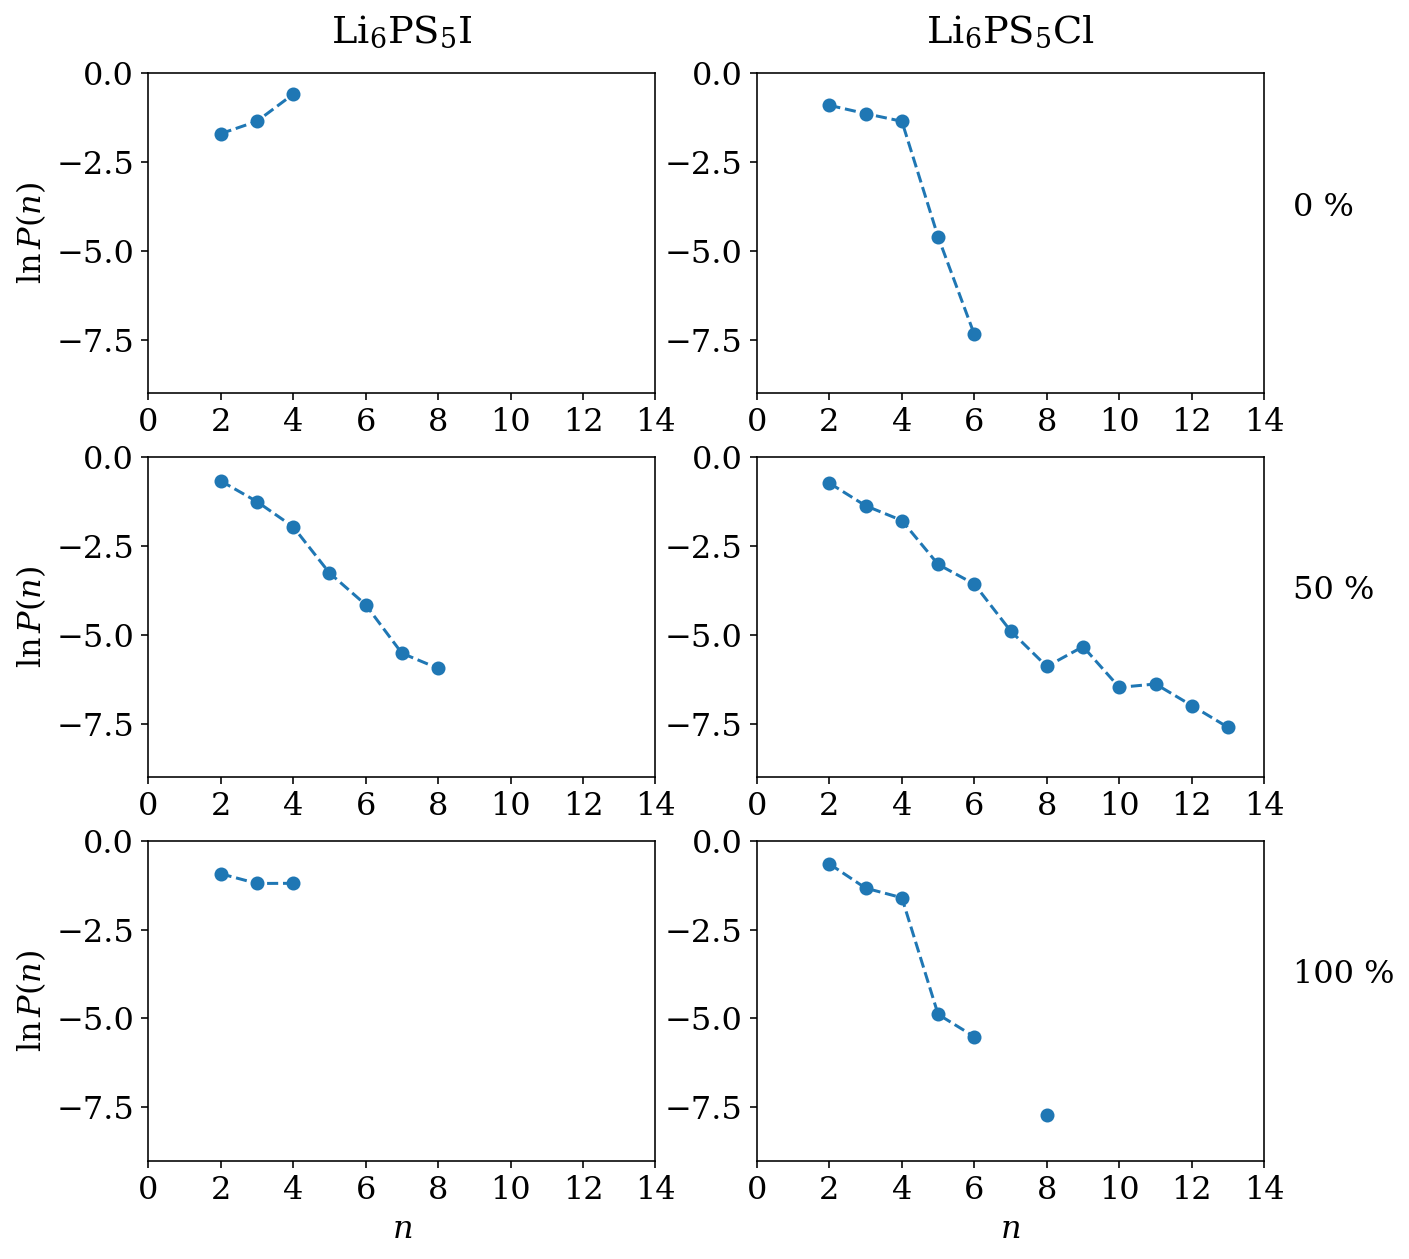

In [4]:
# Plot the string probability distributions

from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Minion Pro']
rcParams['font.size'] = 16
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['mathtext.fontset'] = 'dejavuserif'

xlabel = r'$n$'
ylabel = r'$\ln\,P(n)$'

def plot_string_lengths(string_data, axes, label=None):
    count = string_data.length_counter()
    for i in range(12):
        if i not in count.keys():
            count[i] = 0
    labels, values = zip(*sorted(count.items()))
    values = np.array(values)*np.arange(len(values))
    normalised_values = np.array([ v/sum(values) for v in values])
    indexes = np.arange(len(labels))
    axes.plot(indexes, np.log(normalised_values), 'o--')
              
# sigma = 0.1
fig, ax = plt.subplots(3,2,figsize=(10,10))

for i in [50]:
    label = r'$\Delta t =$' + str(i/10) + ' ps'
    plot_string_lengths(string_data_dt['Li6PS5I']['0p'][i], axes=ax[0,0], label=label)
    plot_string_lengths(string_data_dt['Li6PS5I']['50p'][i], axes=ax[1,0], label=label)
    plot_string_lengths(string_data_dt['Li6PS5I']['100p'][i], axes=ax[2,0], label=label)
    plot_string_lengths(string_data_dt['Li6PS5Cl']['0p'][i], axes=ax[0,1], label=label)
    plot_string_lengths(string_data_dt['Li6PS5Cl']['50p'][i], axes=ax[1,1], label=label)
    plot_string_lengths(string_data_dt['Li6PS5Cl']['100p'][i], axes=ax[2,1], label=label)

y_max = 3
for i in range(3):
    for j in range(2):
        ax[i,j].set_xlim([0,14])
        ax[i,j].set_ylim([-9,0])

for i in range(3):
    for j in range(2):
        ax[i,j].set_xticks(range(0,15,2))
ax[0,0].set_title(r'Li$_6$PS$_5$I', pad=15)
ax[0,1].set_title(r'Li$_6$PS$_5$Cl', pad=15)
ax[2,0].set(xlabel=xlabel, ylabel=ylabel)
ax[1,0].set(ylabel=ylabel)
ax[0,0].set(ylabel=ylabel)
ax[2,1].set(xlabel=xlabel)

ax[0,1].text(14.8,-4,'0 %')
ax[1,1].text(14.8,-4,'50 %')
ax[2,1].text(14.8,-4,'100 %')

fig.show()

In [5]:
string_data_dt

{'Li6PS5I': {'0p': {50: <strings.StringCollection at 0x13bfcbbe0>},
  '50p': {50: <strings.StringCollection at 0x13c1a8c18>},
  '100p': {50: <strings.StringCollection at 0x14c16be80>}},
 'Li6PS5Cl': {'0p': {50: <strings.StringCollection at 0x14c36f320>},
  '50p': {50: <strings.StringCollection at 0x14c4ccbe0>},
  '100p': {50: <strings.StringCollection at 0x14c831940>}}}

In [6]:
import warnings
warnings.filterwarnings('ignore')

# For the 50% site-inverted systems, these appear to be geometric distributions. 
# Calculate the least-likelihood estimate for a geometric distribution, and for
# a Poisson distribution for each dataset:

def get_string_stats(sd):
    return np.array(flatten_list([ [k]*v*k for k, v in sd.length_counter().items()]))

def negLogLikelihood_pois(params, data):
    lnl = -np.sum(np.log(poisson.pmf(data, params[0], loc=int(round(params[1])))))
    return lnl

def negLogLikelihood_geom(params, data):
    lnl = -np.sum(np.log(geom.pmf(data, params[0], loc=int(round(params[1])))))
    return lnl

least_likelihood_params = {'geom': {},
                           'pois': {}}

# Li6PS5I 50%
print('\nLi6PS5I 50%')
data = get_string_stats(string_data_dt['Li6PS5I']['50p'][50])
result = differential_evolution(negLogLikelihood_geom,  
                                args=(data,),
                                bounds=((0,1),(0,5)))
print(f'Geometric -log(maximum likelihood): P={result.x[0]}, loc={int(result.x[1])}')
least_likelihood_params['geom']['Li6PS5I'] = result.x[0]

result = differential_evolution(negLogLikelihood_pois,  
                                args=(data,),
                                bounds=((0,5),(0,5)))
print(f'Poisson   -log(maximum likelihood): mu={result.x[0]}, loc={int(result.x[1])}')
least_likelihood_params['pois']['Li6PS5I'] = result.x[0]

# Li6PS5I 50%
print('\nLi6PS5Cl 50%')
data = get_string_stats(string_data_dt['Li6PS5Cl']['50p'][50])
result = differential_evolution(negLogLikelihood_geom,  
                                args=(data,),
                                bounds=((0,1),(0,5)))
print(f'Geometric -log(maximum likelihood): P={result.x[0]}, loc={int(result.x[1])}')
least_likelihood_params['geom']['Li6PS5Cl'] = result.x[0]

result = differential_evolution(negLogLikelihood_pois,   
                                args=(data,),
                                bounds=((0,5),(0,5)))
print(f'Poisson   -log(maximum likelihood): mu={result.x[0]}, loc={int(result.x[1])}')
least_likelihood_params['pois']['Li6PS5Cl'] = result.x[0]


Li6PS5I 50%
Geometric -log(maximum likelihood): P=0.5614006636225765, loc=0
Poisson   -log(maximum likelihood): mu=0.781761617529838, loc=2

Li6PS5Cl 50%
Geometric -log(maximum likelihood): P=0.5049922022771599, loc=1
Poisson   -log(maximum likelihood): mu=0.9793921340947613, loc=2


[-0.57732043 -1.40148939 -2.22565835 -3.0498273  -3.87399626 -4.69816521
 -5.52233417]


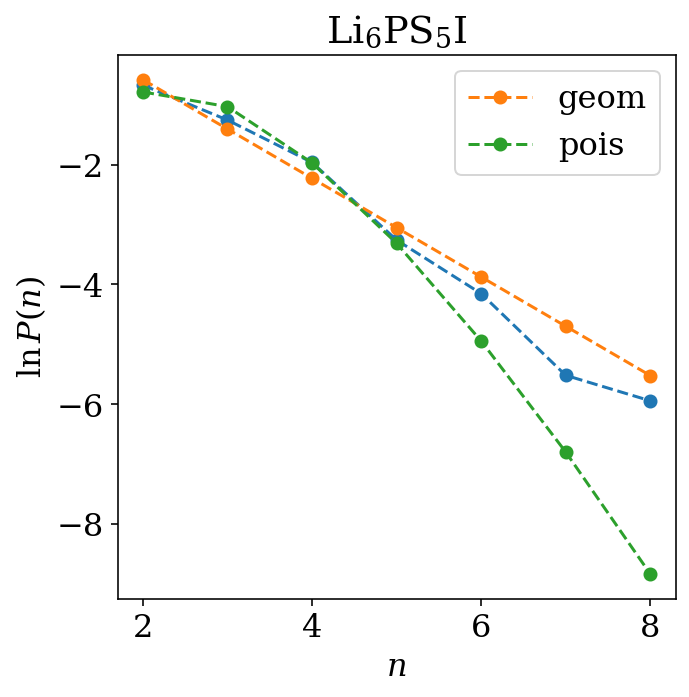

In [7]:
system = 'Li6PS5I'

fig, ax = plt.subplots(1,1,figsize=(5,5))
for i in [50]:
    plot_string_lengths(string_data_dt[system]['50p'][i], axes=ax, label=label)

x = np.arange(2,9)
estimate = geom.pmf(x, p=least_likelihood_params['geom'][system], loc=1)
print(np.log(estimate))
ax.plot(x, np.log(estimate), 'o--', label='geom')

estimate2 = poisson.pmf(x, mu=least_likelihood_params['pois'][system], loc=2)
ax.plot(x, np.log(estimate2), 'o--', label='pois')

plt.title(r'Li$_6$PS$_5$I')
plt.legend()
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()

[-0.68321229 -1.38639405 -2.08957582 -2.79275758 -3.49593935 -4.19912111
 -4.90230287 -5.60548464 -6.3086664  -7.01184816 -7.71502993 -8.41821169]


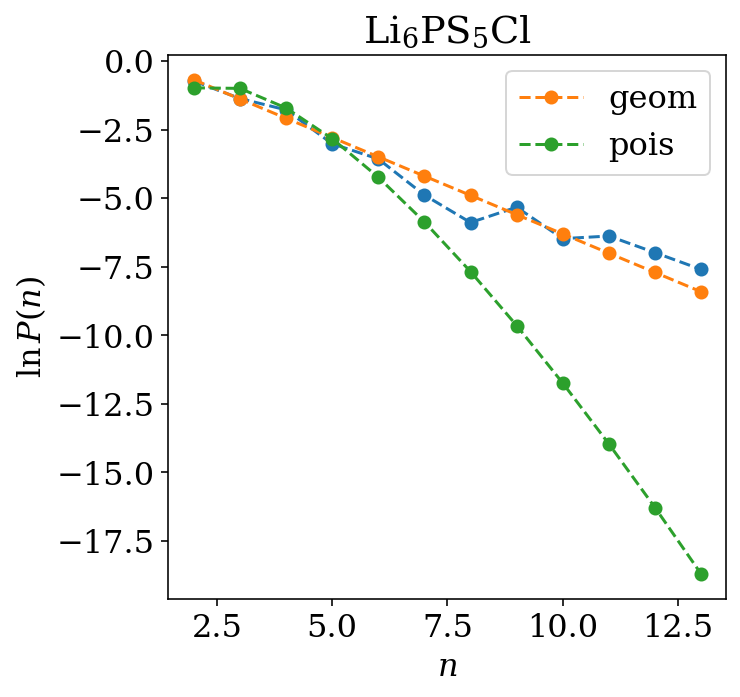

In [8]:
system = 'Li6PS5Cl'

fig, ax = plt.subplots(1,1,figsize=(5,5))
for i in [50]:
    plot_string_lengths(string_data_dt[system]['50p'][i], axes=ax, label=label)

x = np.arange(2,14)
estimate = geom.pmf(x, p=least_likelihood_params['geom'][system], loc=1)
print(np.log(estimate))
ax.plot(x, np.log(estimate), 'o--', label='geom')

estimate2 = poisson.pmf(x, mu=least_likelihood_params['pois'][system], loc=2)
ax.plot(x, np.log(estimate2), 'o--', label='pois')

plt.title(r'Li$_6$PS$_5$Cl')
plt.legend()
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()

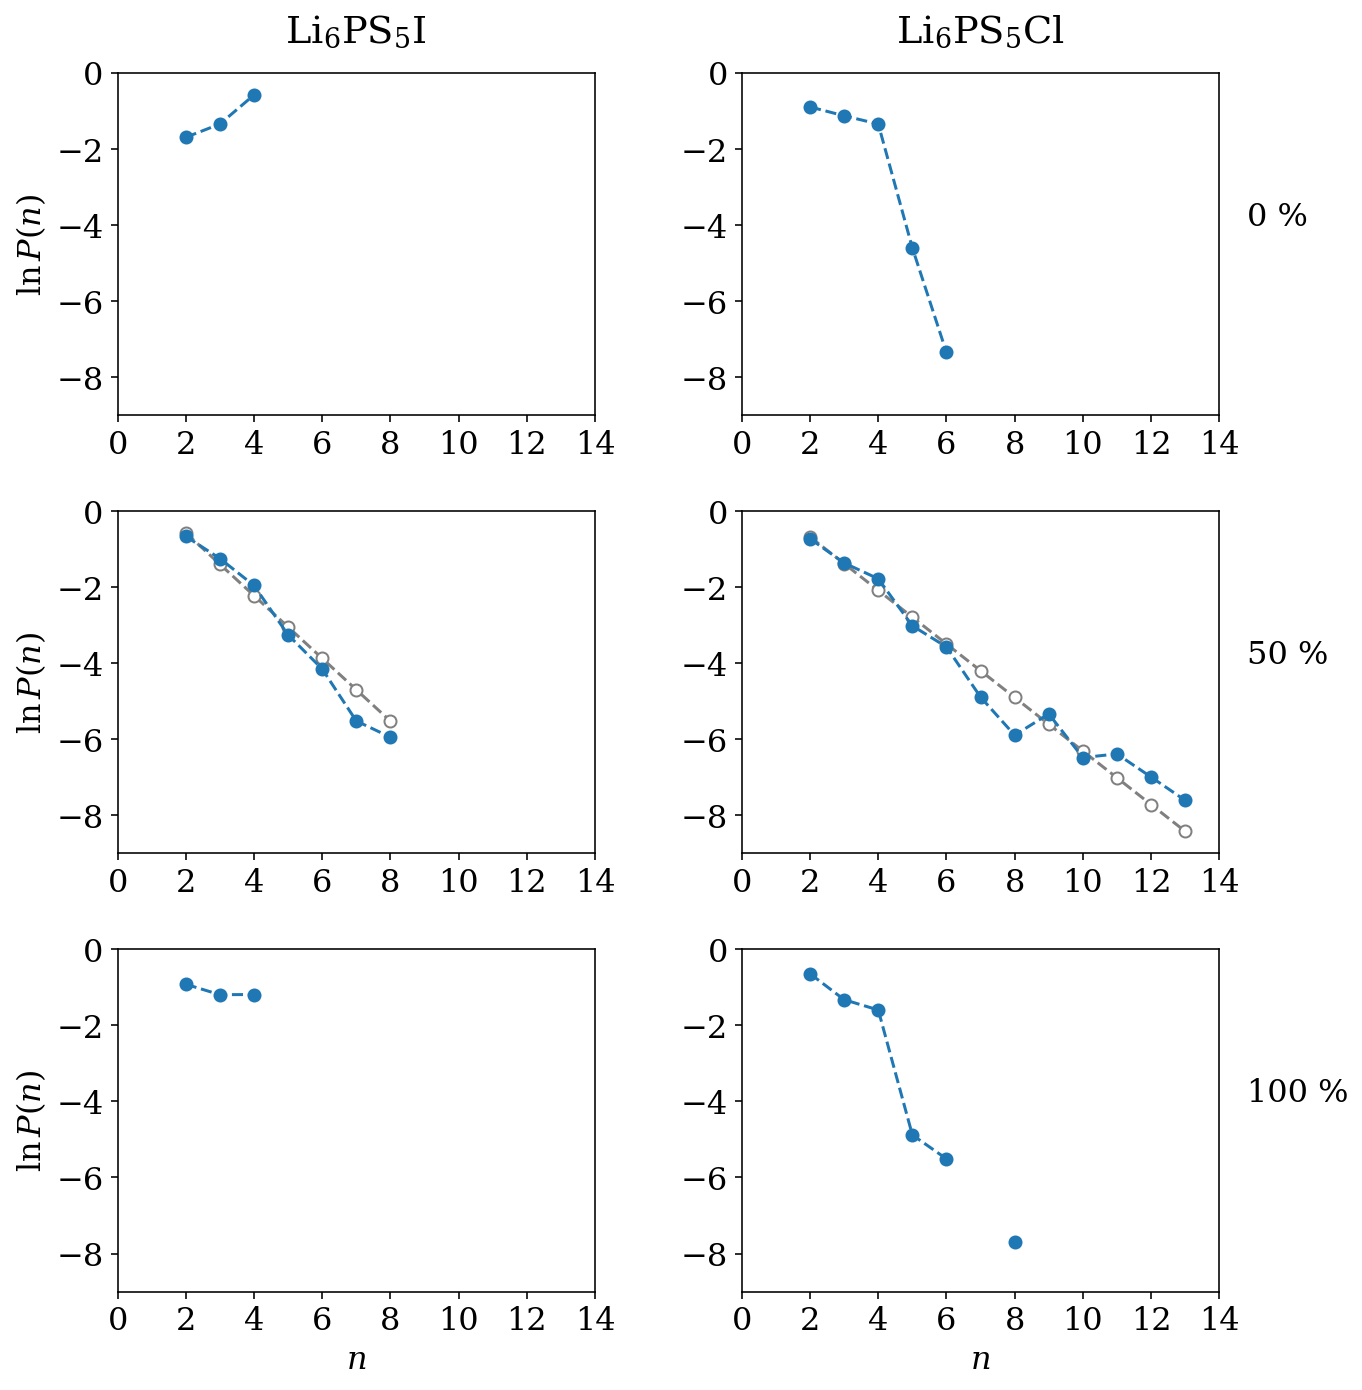

In [9]:
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Minion Pro']
rcParams['font.size'] = 16
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['mathtext.fontset'] = 'dejavuserif'

xlabel = r'$n$'
ylabel = r'$\ln\,P(n)$'

def plot_string_lengths(string_data, axes, label=None):
    count = string_data.length_counter()
    for i in range(12):
        if i not in count.keys():
            count[i] = 0
    labels, values = zip(*sorted(count.items()))
    values = np.array(values)*np.arange(len(values))
    normalised_values = np.array([ v/sum(values) for v in values])
    indexes = np.arange(len(labels))
    axes.plot(indexes, np.log(normalised_values), 'o--')
              
sigma = 0.1
fig, ax = plt.subplots(3,2,figsize=(10,10))

for i in [50]:
    label = r'$\Delta t =$' + str(i/10) + ' ps'
    plot_string_lengths(string_data_dt['Li6PS5I']['0p'][i], axes=ax[0,0], label=label)
    plot_string_lengths(string_data_dt['Li6PS5I']['50p'][i], axes=ax[1,0], label=label)
    plot_string_lengths(string_data_dt['Li6PS5I']['100p'][i], axes=ax[2,0], label=label)
    plot_string_lengths(string_data_dt['Li6PS5Cl']['0p'][i], axes=ax[0,1], label=label)
    plot_string_lengths(string_data_dt['Li6PS5Cl']['50p'][i], axes=ax[1,1], label=label)
    plot_string_lengths(string_data_dt['Li6PS5Cl']['100p'][i], axes=ax[2,1], label=label)

y_max = 3
for i in range(3):
    for j in range(2):
        ax[i,j].set_xlim([0,14])
        ax[i,j].set_ylim([-9,0])

for i in range(3):
    for j in range(2):
        ax[i,j].set_xticks(range(0,15,2))
ax[0,0].set_title(r'Li$_6$PS$_5$I', pad=15)
ax[0,1].set_title(r'Li$_6$PS$_5$Cl', pad=15)
ax[2,0].set(xlabel=xlabel, ylabel=ylabel)
ax[1,0].set(ylabel=ylabel)
ax[0,0].set(ylabel=ylabel)
ax[2,1].set(xlabel=xlabel)

ax[0,1].text(14.8,-4,'0 %')
ax[1,1].text(14.8,-4,'50 %')
ax[2,1].text(14.8,-4,'100 %')

x = np.arange(2,14)
estimate = geom.pmf(x, p=least_likelihood_params['geom']['Li6PS5Cl'], loc=1) # where do these numbers come from?
ax[1,1].plot(x, np.log(estimate), 'o--', c='grey', zorder=0, markerfacecolor='white', markeredgecolor='grey')

x = np.arange(2,9)
estimate = geom.pmf(x, p=least_likelihood_params['geom']['Li6PS5I'], loc=1)
ax[1,0].plot(x, np.log(estimate), 'o--', c='grey', zorder=0, markerfacecolor='white', markeredgecolor='grey')


    
fig.tight_layout()    
# fig.subplots_adjust(wspace=0, hspace=0)
fig.savefig('../../figures/string_populations.pdf', tight_layout=True)
fig.show()

In [10]:
%load_ext version_information

%version_information pymatgen, matplotlib, numpy, yaml, scipy

Software versions
Python 3.7.0 64bit [Clang 10.0.0 (clang-1000.10.44.2)]
IPython 7.0.1
OS Darwin 19.4.0 x86_64 i386 64bit
pymatgen 2020.1.28
matplotlib 3.2.0rc1
numpy 1.18.3
yaml 5.2
scipy 1.4.1
Fri May 22 14:23:59 2020 BST